## Clustering sobre entidades nombradas del corpus de Infoleg 

### Text-mining, FAMAF- 2019

In [1]:
import os
import re
import spacy
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from spacy.tokens import Doc
from nltk import regexp_tokenize
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction import DictVectorizer
from patterns import PATTERN, IS_NE
from sklearn.manifold import TSNE
from scipy.spatial import distance
from nltk.cluster import KMeansClusterer, cosine_distance

### Tokenización del corpus de infoleg 

Parte tomada de https://github.com/lucasdefrancesca/FAMAF-text-mining/. Mi compañero del curso, Lucas DeFrancesca quien utilizó expresiones regulares para tokenizar correctamente las entidades nombradas de dominio legal. Las mismas fueron anotadas manualmente por el compañero Dr.Fernando Cardellino.

In [2]:
# Settings pathfiles
dname = './corpus_infoleg/'

In [3]:
# From https://github.com/lucasdefrancesca/FAMAF-text-mining/
class CustomTokenizer(object):
    def __init__(self, vocab):
        self.vocab = vocab

    def __call__(self, text):
        words = regexp_tokenize(text, PATTERN)
        # All tokens 'own' a subsequent space character in this tokenizer
        spaces = [True] * len(words)
        return Doc(self.vocab, words=words, spaces=spaces)

In [4]:
# From https://github.com/lucasdefrancesca/FAMAF-text-mining/
def preProcessing(dname, PATTERN):
    """
    input: directory name
    output: tokenizer doc, without stop-words, punctuation and digit
    """
    tokenizer = []
    nlp = spacy.load("es")
    nlp.tokenizer = CustomTokenizer(nlp.vocab)
    for file in os.listdir(dname):
        if file.endswith(".txt"):
            with open(os.path.join(dname, file), "r", encoding='utf8') as fd:
                for document in fd.readlines():
                    document = document.strip()
                    nlp.max_length = max(len(document), nlp.max_length)
                
                    tokens = [ token for token in nlp(document) 
                        if not (token.is_stop or token.is_punct or token.is_digit or len(token.text)==1) ]
                    
                    tokenizer.append(tokens)
    return tokenizer

In [5]:
# From https://github.com/lucasdefrancesca/FAMAF-text-mining/
def isEntity(string, pattern):
    """
    input: string and pattern
    output: true if string is named entity
    """
    return re.match(pattern, string) != None

In [6]:
tokenizer = preProcessing(dname, PATTERN)

### Matriz de coocurrencias

Para armar la matriz de features de las entidades nombradas se toman las coocurrencias de palabras dentro de una ventana de tamaño 5. Es decir, 5 palabras a la izquierda y 5 palabras a la derecha. Tener en cuenta que ya se han eliminado las stop words, puntuaciones y dígitos que no esten en las entidades nombradas.

In [7]:
def dict_features(sentences,w):
    """Toma como entrada una lista de listas, cada sublista es una oración.
        Devuelve una lista de diccionarios con las coocurrencias y una lista de palabras para los índices de la matriz. 
        El contexto es una ventana variable de tamaño w"""
    
    features = [] # lista de diccionarios
    idx = [] # lista de palabras
    for sent in sentences:
        for m,tok in enumerate(sent):
            word = tok.text
            if isEntity(word, IS_NE):
                
                neighbors = []
                # neighbors on the right
                for l in range(1,w+1):
                    if m+l > len(sent)-1:
                        break
                    else:
                        neighbors.append(sent[m+l].text)
                # neighbors on the left
                for l in range(1,w+1):
                    if m-l < 0:
                        break
                    else:
                        neighbors.append(sent[m-l].text)
                
                
                # para agregar los vecinos de una nueva palabra
                if word in idx:
                    i = idx.index(word)
                    features[i][word] +=1
                else :
                    features.append({word:1}) 
                    idx.append(word)
                    i = idx.index(word)
    
                for v in neighbors:
                    if not v in features[i]:
                        features[i][v] =1
                    else:
                        features[i][v] +=1
                        

    return features, idx

In [8]:
coocurrences, idx = dict_features(tokenizer,5)
# Se obtiene la matriz de coocurrencias
vectorizer = DictVectorizer()
vec = vectorizer.fit_transform(coocurrences)
# Se muestra en un dataframe
columns=vectorizer.get_feature_names()
matrix = pd.DataFrame(vec.toarray(), columns=columns)
matrix = matrix.set_axis(idx,axis=0, inplace=False)
matrix

,04-05,06 de abril de 2009,1 de agosto de 2003,1 de diciembre de 1987,1 de mayo de 2017,10 de diciembre de 1998,10 de julio de 1997,10 de julio de 2007,10 de junio de 2009,10 de marzo de 2008,...,vinculados,virtud,voluntarios,volúmenes,válido,zona,zonas,ámbito,área,órbita
Ley N° 26.178,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Eduardo D. Rollano,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Juan H. Estrada,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Resolución 3208/2005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Ley No 24.076,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ley N° 27.266,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Decreto Nacional Nº 2089/93,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Decreto N° 565/2008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Ley N° 27.250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Reducción de dimensionalidad con TruncatedSVD

In [9]:
svd = TruncatedSVD(n_components=30, n_iter=7, random_state=123)
matrix_reduced = svd.fit_transform(matrix.values) 

In [10]:
svd.explained_variance_ratio_[:30].sum()

0.854034348273646

### Visualización con Tsne

In [11]:
viz = TSNE(n_components=2, metric='cosine', init='pca', random_state=123)
t_sne = viz.fit_transform(matrix_reduced)

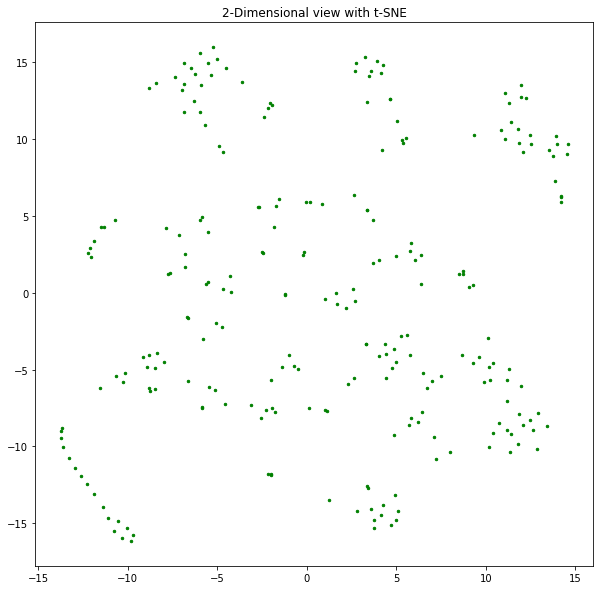

In [23]:
plt.figure(figsize=(10,10)) 

plt.scatter(t_sne[:, 0], t_sne[:, 1], s=6, c='g')
plt.title("2-Dimensional view with t-SNE")
plt.axis('tight')

plt.show()

### Clustering

Se utiliza el método elbow para elegir el número de clusters. Se grafica la inercia del clusterizado en función del número de clusters. Ésta medida de inercia es la suma de las distancias al cuadrado de cada elemento del cluster a su centroide correspondiente. Se toma donde la curva disminuye su inercia abruptamente al aumentar el número de clusters para elegir el mismo.

Para el clustering se usa __kmeans__ de __NLTK__ con la __distancia coseno__. Por ello mismo, para calcular la inercia se toma la misma medida en valor absoluto, considerando que la distancia al coseno puede estar en [-1,1].

In [14]:
inertias = []
for k in range(5, 45, 5):
    
    clusterer = KMeansClusterer(k, cosine_distance, avoid_empty_clusters=True)
    labels = clusterer.cluster(matrix_reduced, True)
    
    centroids = clusterer.means()
    #centros = {}
    #for idx,mean in enumerate(centroids):
    #    centros[idx] = mean
    
    inertia = 0
    for i in range(0,len(matrix_reduced)):
        inertia += math.sqrt(math.pow(distance.cosine(matrix_reduced[i,:], centroids[labels[i]]),2))
    
    inertias.append(inertia)
        
        

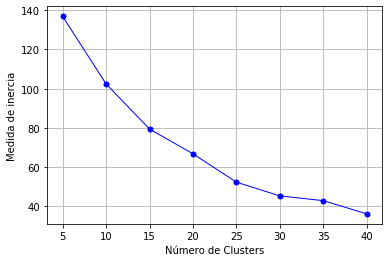

In [15]:
plt.plot(range(5, 45, 5), inertias, 'bo-', markersize=5, lw=1)
plt.grid(True)
plt.xlabel('Número de Clusters')
plt.ylabel('Medida de inercia')
plt.show()

Usando el método del codo se esta entre 10 y 15 clusters, eligiendo 15 pues tiene menor inercia.

In [18]:
clusterer = KMeansClusterer(15, cosine_distance, avoid_empty_clusters=True)
labels = clusterer.cluster(matrix_reduced, True)

n_clusters = clusterer.num_clusters()

print('Número de clusters encontrados: ', n_clusters)
clusters = pd.DataFrame({'Entidades_Nombradas':matrix.index, 'Etiqueta':labels})

Número de clusters encontrados:  15


In [19]:
clusters.head()

,Entidades_Nombradas,Etiqueta
0,Ley N° 26.178,3
1,Eduardo D. Rollano,5
2,Juan H. Estrada,5
3,Resolución 3208/2005,0
4,Ley No 24.076,3


In [20]:
clusters.groupby('Etiqueta').count()

,Entidades_Nombradas
Etiqueta,
0,21
1,11
2,15
3,25
4,23
5,10
6,13
7,31
8,14


In [21]:
for i in range(0,n_clusters):
    print('Cluster ', i, ': ', list(clusters[clusters.Etiqueta==i].Entidades_Nombradas),'\n')

Cluster  0 :  ['Resolución 3208/2005', 'Resolución General Nº 1345', 'Resolución General Nº 18', 'Ley Nº 24.402', 'Resolución General Nº 4210', 'Ley Nº 19.640', 'Ley Nº 13.041', 'Resolución General N° 3', 'Resolución General N° 2', 'Expediente ENRE Nº 22', 'Decreto 979/2008', 'Resolución de este Ministerio Nº 1919', 'Resolución de este Ministerio Nº 419/2008', 'Resolución del MINISTERIO DE ECONOMIA Y PRODUCCION Nº 127', 'Resolución Nº 534', 'Ley Nº 22.415', 'Resolución Nº 127', 'Nota Externa 59/2009', 'Resolución 474/2009', 'Resolución Nº 834/02', 'Ley Nº 22.802'] 

Cluster  1 :  ['Nota Externa (DGA) Nº 52', 'Nota Externa (DGA) Nº 57', 'Nota Externa (DGA) Nº 72', 'Nota Externa (DGA) Nº 75', 'Nota Externa (DGA) Nº 81', 'Nota Externa (DGA) Nº 95', 'Nota Externa (DGA) Nº 7', 'Nota Externa (DGA) Nº 36', 'Nota Externa (DGA) Nº 40', 'Nota Externa (DGA) Nº 51', 'Nota Externa (DGA) Nº 56'] 

Cluster  2 :  ['Resolución SE Nº 659/2004', 'Ley N° 24.076', 'Decretos Nº 1738/92', 'Decreto Nº 1759/72

### Testigos para examinar:

Resolución 3208/2005_ del ENTE NACIONAL REGULADOR DEL GAS, APRUEBANSE, EN FORMA PROVISORIA, LOS CUADROS TARIFARIOS

Resolución de este Ministerio Nº 419/2008_ ESTABLECENSE LA ESTRUCTURA ORGANIZATIVA Y REQUISITOS DE SEGURIDAD Y EQUIPAMIENTO QUE DEBEN REUNIR LAS ASOCIACIONES DE BOMBEROS VOLUNTARIOS 

LEY N° 22.415_ Servicio aduanero 

Ley 24.076_ Regulación del transporte y distribución de gas natural - Privatización de Gas del Estado

Ley Nº 25.054_ LEY DEL BOMBERO VOLUNTARIO

Ley Nº 19.640_ Se establece un Régimen Fiscal y Aduanero para el territorio Nacional de Tierra del Fuego Antártida e Islas del Atlántico Sur.

Ley Nº 26.422_ PRESUPUESTO DE GASTOS Y RECURSOS ADMINISTRACION NACIONAL EJERCICIO 2009 - APROBACION

Resolución General Nº 2204_ Impuesto a las Ganancias. Registro de entidades exentas.

Fulvio M. Madaro_ extitulas de Energas

LEY Nº 25.561_ LEY DE EMERGENCIA PUBLICA Y DE REFORMA DEL RÉGIMEN CAMBIARIO 

Ley Nº 25.156_ Ley de Competencia

Ley 13.064_ OBRAS PUBLICAS

Ley N° 27.266_ Defensa del consumidor

Ley N° 26.361_ Modificación a la ley de defensa del consumidor

Ley N° 27.250_ Defensa de Consumidores y Usuarios